In [1]:
!git clone https://github.com/usuyama/pytorch-unet

Cloning into 'pytorch-unet'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 55 (delta 2), reused 1 (delta 0), pack-reused 48
Unpacking objects: 100% (55/55), done.


In [2]:
cd "/content/pytorch-unet"

/content/pytorch-unet


In [0]:
import matplotlib.pyplot as plt
import numpy as np
import helper
import simulation
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

class SimDataset(Dataset):
    def __init__(self, count, transform=None):
        self.input_images, self.target_masks = simulation.generate_random_data(192, 192, count=count)
        self.transform = transform

    def __len__(self):
        return len(self.input_images)

    def __getitem__(self, idx):
        image = self.input_images[idx]
        mask = self.target_masks[idx]
        if self.transform:
            image = self.transform(image)

        return [image, mask]

# use the same transformations for train/val in this example
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])

train_set = SimDataset(1000, transform = trans)
val_set = SimDataset(100, transform = trans)

image_datasets = {
    'train': train_set, 'val': val_set
}

batch_size = 25

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
}

In [4]:
for data in tqdm(dataloaders['train']):
  inputs, labels = data[0], data[1]

NameError: ignored

In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [0]:
count_parameters(model)

In [0]:
from __future__ import print_function
from tqdm import tqdm, tqdm_notebook

In [0]:
print(inputs.size(), labels.size())

In [5]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import PIL
import skimage.measure
from tqdm import tqdm, tqdm_notebook
!pip install git+https://github.com/rtqichen/torchdiffeq
from torchdiffeq import odeint, odeint_adjoint

MAX_NUM_STEPS = 1000  # Maximum number of steps for ODE solver

class ODEBlock(nn.Module):
    def __init__(self, odefunc, tol=10, adjoint=False):
        """
        Code adapted from https://github.com/EmilienDupont/augmented-neural-odes
        Utility class that wraps odeint and odeint_adjoint.
        Args:
            odefunc (nn.Module): the module to be evaluated
            tol (float): tolerance for the ODE solver
            adjoint (bool): whether to use the adjoint method for gradient calculation
        """
        super(ODEBlock, self).__init__()
        self.adjoint = adjoint
        self.odefunc = odefunc
        self.tol = tol

    def forward(self, x, eval_times=None):
        # Forward pass corresponds to solving ODE, so reset number of function
        # evaluations counter
        self.odefunc.nfe = 0

        if eval_times is None:
            integration_time = torch.tensor([0, 1]).float().type_as(x)
        else:
            integration_time = eval_times.type_as(x)

        if self.adjoint:
            out = odeint_adjoint(self.odefunc, x, integration_time,
                                 rtol=self.tol, atol=self.tol, method='euler',
                                 options={'max_num_steps': MAX_NUM_STEPS})
        else:
            out = odeint(self.odefunc, x, integration_time,
                         rtol=self.tol, atol=self.tol, method='euler',
                         options={'max_num_steps': MAX_NUM_STEPS})

        if eval_times is None:
            return out[1]  # Return only final time
        else:
            return out

    def trajectory(self, x, timesteps):
        integration_time = torch.linspace(0., 1., timesteps)
        return self.forward(x, eval_times=integration_time)


class Conv2dTime(nn.Conv2d):
    def __init__(self, in_channels, *args, **kwargs):
        """
        Code adapted from https://github.com/EmilienDupont/augmented-neural-odes
        Conv2d module where time gets concatenated as a feature map.
        Makes ODE func aware of the current time step.
        """
        super(Conv2dTime, self).__init__(in_channels + 1, *args, **kwargs)

    def forward(self, t, x):
        # Shape (batch_size, 1, height, width)
        t_img = torch.ones_like(x[:, :1, :, :]) * t
        # Shape (batch_size, channels + 1, height, width)
        t_and_x = torch.cat([t_img, x], 1)
        return super(Conv2dTime, self).forward(t_and_x)

def get_nonlinearity(name):
    """Helper function to get non linearity module, choose from relu/softplus/swish/lrelu"""
    if name == 'relu':
        return nn.ReLU(inplace=True)
    elif name == 'softplus':
        return nn.Softplus()
    elif name == 'swish':
        return Swish(inplace=True)
    elif name == 'lrelu':
        return nn.LeakyReLU()

class Swish(nn.Module):
    def __init__(self, inplace=False):
        """The Swish non linearity function"""
        super().__init__()
        self.inplace = True

    def forward(self, x):
        if self.inplace:
            x.mul_(F.sigmoid(x))
            return x
        else:
            return x * F.sigmoid(x)

class ConvODEFunc(nn.Module):
    def __init__(self, num_filters, time_dependent=False, non_linearity='relu'):
        """
        Block for ConvODEUNet
        Args:
            num_filters (int): number of filters for the conv layers
            time_dependent (bool): whether to concat the time as a feature map before the convs
            non_linearity (str): which non_linearity to use (for options see get_nonlinearity)
        """
        super(ConvODEFunc, self).__init__()
        nf = num_filters
        self.time_dependent = time_dependent
        self.nfe = 0  # Number of function evaluations

        self.norm = nn.InstanceNorm2d(nf)
        if time_dependent:
            self.conv1 = Conv2dTime(nf, nf, kernel_size=3, stride=1, padding=1)
            self.conv2 = Conv2dTime(nf, nf, kernel_size=3, stride=1, padding=1)
        else:
            self.conv1 = nn.Conv2d(nf, nf, kernel_size=3, stride=1, padding=1)
            self.conv2 = nn.Conv2d(nf, nf, kernel_size=3, stride=1, padding=1)

        self.non_linearity = get_nonlinearity(non_linearity)

    def forward(self, t, x):
        self.nfe += 1
        out = self.norm(x)
        out = self.conv1(t, out) if self.time_dependent else self.conv1(out)
        out = self.non_linearity(out)
        out = self.norm(out)
        out = self.conv2(t, out) if self.time_dependent else self.conv2(out)
        out = self.non_linearity(out)
        return out

class ConvODEUNet(nn.Module):
    def __init__(self, num_filters, output_dim=6, time_dependent=False,
                 non_linearity='softplus', tol=10, adjoint=False):
        """
        ConvODEUNet (U-Node in paper)
        Args:
            num_filters (int): number of filters for first conv layer
            output_dim (int): how many feature maps the network outputs
            time_dependent (bool): whether to concat the time as a feature map before the convs
            non_linearity (str): which non_linearity to use (for options see get_nonlinearity)
            tol (float): tolerance to be used for ODE solver
            adjoint (bool): whether to use the adjoint method to calculate the gradients
        """
        super(ConvODEUNet, self).__init__()
        nf = num_filters

        self.input_1x1 = nn.Conv2d(3, nf, 1, 1)

        ode_down1 = ConvODEFunc(nf, time_dependent, non_linearity)
        self.odeblock_down1 = ODEBlock(ode_down1, tol=tol, adjoint=adjoint)
        self.conv_down1_2 = nn.Conv2d(nf, nf*2, 1, 1)

        ode_down2 = ConvODEFunc(nf*2, time_dependent, non_linearity)
        self.odeblock_down2 = ODEBlock(ode_down2, tol=tol, adjoint=adjoint)
        self.conv_down2_3 = nn.Conv2d(nf*2, nf*4, 1, 1)

        ode_down3 = ConvODEFunc(nf*4, time_dependent, non_linearity)
        self.odeblock_down3 = ODEBlock(ode_down3, tol=tol, adjoint=adjoint)
        self.conv_down3_4 = nn.Conv2d(nf*4, nf*8, 1, 1)

        ode_down4 = ConvODEFunc(nf*8, time_dependent, non_linearity)
        self.odeblock_down4 = ODEBlock(ode_down4,  tol=tol, adjoint=adjoint)
        self.conv_down4_embed = nn.Conv2d(nf*8, nf*16, 1, 1)

        ode_embed = ConvODEFunc(nf*16, time_dependent, non_linearity)
        self.odeblock_embedding = ODEBlock(ode_embed,  tol=tol, adjoint=adjoint)

        self.conv_up_embed_1 = nn.Conv2d(nf*16+nf*8, nf*8, 1, 1)
        ode_up1 = ConvODEFunc(nf*8, time_dependent, non_linearity)
        self.odeblock_up1 = ODEBlock(ode_up1, tol=tol, adjoint=adjoint)

        self.conv_up1_2 = nn.Conv2d(nf*8+nf*4, nf*4, 1, 1)
        ode_up2 = ConvODEFunc(nf*4, time_dependent, non_linearity)
        self.odeblock_up2 = ODEBlock(ode_up2, tol=tol, adjoint=adjoint)

        self.conv_up2_3 = nn.Conv2d(nf*4+nf*2, nf*2, 1, 1)
        ode_up3 = ConvODEFunc(nf*2, time_dependent, non_linearity)
        self.odeblock_up3 = ODEBlock(ode_up3, tol=tol, adjoint=adjoint)

        self.conv_up3_4 = nn.Conv2d(nf*2+nf, nf, 1, 1)
        ode_up4 = ConvODEFunc(nf, time_dependent, non_linearity)
        self.odeblock_up4 = ODEBlock(ode_up4, tol=tol, adjoint=adjoint)

        self.classifier = nn.Conv2d(nf, output_dim, 1)

        self.non_linearity = get_nonlinearity(non_linearity)

    def forward(self, x, return_features=False):
        x = self.non_linearity(self.input_1x1(x))

        features1 = self.odeblock_down1(x)  # 512
        x = self.non_linearity(self.conv_down1_2(features1))
        x = nn.functional.interpolate(x, scale_factor=0.5, mode='bilinear', align_corners=False)

        features2 = self.odeblock_down2(x)  # 256
        x = self.non_linearity(self.conv_down2_3(features2))
        x = nn.functional.interpolate(x, scale_factor=0.5, mode='bilinear', align_corners=False)

        features3 = self.odeblock_down3(x)  # 128
        x = self.non_linearity(self.conv_down3_4(features3))
        x = nn.functional.interpolate(x, scale_factor=0.5, mode='bilinear', align_corners=False)

        features4 = self.odeblock_down4(x)  # 64
        x = self.non_linearity(self.conv_down4_embed(features4))
        x = nn.functional.interpolate(x, scale_factor=0.5, mode='bilinear', align_corners=False)

        x = self.odeblock_embedding(x)  # 32

        x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        x = torch.cat((x, features4), dim=1)
        x = self.non_linearity(self.conv_up_embed_1(x))
        x = self.odeblock_up1(x)

        x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        x = torch.cat((x, features3), dim=1)
        x = self.non_linearity(self.conv_up1_2(x))
        x = self.odeblock_up2(x)

        x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        x = torch.cat((x, features2), dim=1)
        x = self.non_linearity(self.conv_up2_3(x))
        x = self.odeblock_up3(x)

        x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        x = torch.cat((x, features1), dim=1)
        x = self.non_linearity(self.conv_up3_4(x))
        x = self.odeblock_up4(x)

        pred = self.classifier(x)
        return pred
def plot_losses(inputs, outputs, losses, val_losses, title, nfe=None, net=None):
    # plot statistics
    if nfe is not None:
        nfe[0].append(net.odeblock_down1.odefunc.nfe)
        nfe[1].append(net.odeblock_down2.odefunc.nfe)
        nfe[2].append(net.odeblock_down3.odefunc.nfe)
        nfe[3].append(net.odeblock_down4.odefunc.nfe)
        nfe[4].append(net.odeblock_embedding.odefunc.nfe)
        nfe[5].append(net.odeblock_up1.odefunc.nfe)
        nfe[6].append(net.odeblock_up2.odefunc.nfe)
        nfe[7].append(net.odeblock_up3.odefunc.nfe)
        nfe[8].append(net.odeblock_up4.odefunc.nfe)

    if nfe is not None: cols = 4
    else: cols = 3
    fig, ax = plt.subplots(nrows=1, ncols=cols, figsize=(15, 5))

    fig.suptitle(title, fontsize=16)

    ax[0].plot(np.arange(len(losses)), losses, label="loss")
    ax[0].plot(np.arange(len(val_losses)), val_losses, label="val_loss")

    if nfe is not None:
        ax[3].plot(np.arange(len(nfe[0])), nfe[0], label="down1")
        ax[3].plot(np.arange(len(nfe[0])), nfe[1], label="down2")
        ax[3].plot(np.arange(len(nfe[0])), nfe[2], label="down3")
        ax[3].plot(np.arange(len(nfe[0])), nfe[3], label="down4")
        ax[3].plot(np.arange(len(nfe[0])), nfe[4], label="embed")
        ax[3].plot(np.arange(len(nfe[0])), nfe[5], label="up1")
        ax[3].plot(np.arange(len(nfe[0])), nfe[6], label="up2")
        ax[3].plot(np.arange(len(nfe[0])), nfe[7], label="up3")
        ax[3].plot(np.arange(len(nfe[0])), nfe[8], label="up4")
        ax[3].legend()

    outputs = torch.argmax(torch.softmax(outputs, dim=1), dim=1)[0]
    outputs = outputs.detach().cpu()
    outputs = outputs.numpy()

    ax[0].legend()
    ax[1].imshow(outputs)
    ax[2].imshow(inputs.detach().cpu()[0].numpy().transpose(1, 2, 0))

    plt.show()

  Cloning https://github.com/rtqichen/torchdiffeq to /tmp/pip-req-build-etrrdwlo
  Running command git clone -q https://github.com/rtqichen/torchdiffeq /tmp/pip-req-build-etrrdwlo
  Created wheel for torchdiffeq: filename=torchdiffeq-0.0.1-cp36-none-any.whl size=25884 sha256=3253b4779dee58f8f45580736215f44ce63f249e8e831cb6c9f6dd46abb1d839
  Stored in directory: /tmp/pip-ephem-wheel-cache-z3y6wprf/wheels/3f/76/69/01867bf3355c3bc8bae7e556b17b44c395b6cda5e76fd8ddc7
Successfully built torchdiffeq


In [0]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
from collections import defaultdict
import torch.nn.functional as F
from loss import dice_loss

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss

def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])

                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [7]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 6
model = ConvODEUNet(num_filters=16, output_dim=6, time_dependent=True, 
                      non_linearity='lrelu', adjoint=True, tol=10).to(device)

# freeze backbone layers
#for l in model.base_layers:
#    for param in l.parameters():
#        param.requires_grad = False

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)

model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=60)

cuda:0


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 0/59
----------
LR 0.0001


/usr/local/lib/python3.6/dist-packages/torchdiffeq/_impl/misc.py:81: UserWarning: Euler: Unexpected arguments {'max_num_steps': 1000}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
 50%|█████     | 2/4 [00:00<00:00, 10.36it/s]

train: bce: 0.633481, dice: 0.988836, loss: 0.811159


  0%|          | 0/40 [00:00<?, ?it/s]

val: bce: 0.523632, dice: 0.990647, loss: 0.757140
saving best model
0m 13s
Epoch 1/59
----------
LR 0.0001


 50%|█████     | 2/4 [00:00<00:00, 10.61it/s]

train: bce: 0.382943, dice: 0.988509, loss: 0.685726


  0%|          | 0/40 [00:00<?, ?it/s]

val: bce: 0.182511, dice: 0.987274, loss: 0.584892
saving best model
0m 12s
Epoch 2/59
----------
LR 0.0001


 50%|█████     | 2/4 [00:00<00:00, 10.77it/s]

train: bce: 0.077939, dice: 0.983461, loss: 0.530700


  0%|          | 0/40 [00:00<?, ?it/s]

val: bce: 0.033947, dice: 0.973953, loss: 0.503950
saving best model
0m 12s
Epoch 3/59
----------
LR 0.0001


 50%|█████     | 2/4 [00:00<00:00, 10.50it/s]

train: bce: 0.031016, dice: 0.899848, loss: 0.465432


  0%|          | 0/40 [00:00<?, ?it/s]

val: bce: 0.022230, dice: 0.808973, loss: 0.415602
saving best model
0m 12s
Epoch 4/59
----------
LR 0.0001


 50%|█████     | 2/4 [00:00<00:00, 10.58it/s]

train: bce: 0.023525, dice: 0.769805, loss: 0.396665


  0%|          | 0/40 [00:00<?, ?it/s]

val: bce: 0.022066, dice: 0.730337, loss: 0.376202
saving best model
0m 12s
Epoch 5/59
----------
LR 0.0001


 25%|██▌       | 1/4 [00:00<00:00,  9.64it/s]

train: bce: 0.021516, dice: 0.705392, loss: 0.363454


  0%|          | 0/40 [00:00<?, ?it/s]

val: bce: 0.023206, dice: 0.676335, loss: 0.349771
saving best model
0m 12s
Epoch 6/59
----------
LR 0.0001


 25%|██▌       | 1/4 [00:00<00:00,  9.81it/s]

train: bce: 0.025262, dice: 0.647101, loss: 0.336182


  0%|          | 0/40 [00:00<?, ?it/s]

val: bce: 0.026650, dice: 0.625797, loss: 0.326224
saving best model
0m 12s
Epoch 7/59
----------
LR 0.0001


 50%|█████     | 2/4 [00:00<00:00, 10.85it/s]

train: bce: 0.024424, dice: 0.586251, loss: 0.305337


  0%|          | 0/40 [00:00<?, ?it/s]

val: bce: 0.024533, dice: 0.561666, loss: 0.293100
saving best model
0m 12s
Epoch 8/59
----------
LR 0.0001


 50%|█████     | 2/4 [00:00<00:00, 10.34it/s]

train: bce: 0.023769, dice: 0.552071, loss: 0.287920


  0%|          | 0/40 [00:00<?, ?it/s]

val: bce: 0.025227, dice: 0.531126, loss: 0.278177
saving best model
0m 12s
Epoch 9/59
----------
LR 0.0001


 50%|█████     | 2/4 [00:00<00:00, 10.62it/s]

train: bce: 0.022186, dice: 0.519579, loss: 0.270882


  0%|          | 0/40 [00:00<?, ?it/s]

val: bce: 0.020268, dice: 0.507385, loss: 0.263826
saving best model
0m 12s
Epoch 10/59
----------
LR 0.0001


 25%|██▌       | 1/4 [00:00<00:00,  9.87it/s]

train: bce: 0.019042, dice: 0.515063, loss: 0.267053


  0%|          | 0/40 [00:00<?, ?it/s]

val: bce: 0.021622, dice: 0.533775, loss: 0.277699
0m 12s
Epoch 11/59
----------
LR 0.0001


 50%|█████     | 2/4 [00:00<00:00, 10.71it/s]

train: bce: 0.020904, dice: 0.504338, loss: 0.262621


  0%|          | 0/40 [00:00<?, ?it/s]

val: bce: 0.021894, dice: 0.500334, loss: 0.261114
saving best model
0m 12s
Epoch 12/59
----------
LR 0.0001


 50%|█████     | 2/4 [00:00<00:00, 10.37it/s]

train: bce: 0.023492, dice: 0.475343, loss: 0.249418


  0%|          | 0/40 [00:00<?, ?it/s]

val: bce: 0.026512, dice: 0.453998, loss: 0.240255
saving best model
0m 12s
Epoch 13/59
----------
LR 0.0001


 50%|█████     | 2/4 [00:00<00:00, 10.52it/s]

train: bce: 0.023500, dice: 0.437105, loss: 0.230303


  0%|          | 0/40 [00:00<?, ?it/s]

val: bce: 0.023420, dice: 0.414446, loss: 0.218933
saving best model
0m 12s
Epoch 14/59
----------
LR 0.0001


 50%|█████     | 2/4 [00:00<00:00, 10.63it/s]

train: bce: 0.021869, dice: 0.416416, loss: 0.219142


  0%|          | 0/40 [00:00<?, ?it/s]

val: bce: 0.019815, dice: 0.410433, loss: 0.215124
saving best model
0m 12s
Epoch 15/59
----------
LR 0.0001


 25%|██▌       | 1/4 [00:00<00:00,  9.80it/s]

train: bce: 0.020763, dice: 0.407519, loss: 0.214141


  0%|          | 0/40 [00:00<?, ?it/s]

val: bce: 0.020968, dice: 0.423962, loss: 0.222465
0m 12s
Epoch 16/59
----------
LR 0.0001


 50%|█████     | 2/4 [00:00<00:00, 10.77it/s]

train: bce: 0.019946, dice: 0.409535, loss: 0.214741


  0%|          | 0/40 [00:00<?, ?it/s]

val: bce: 0.019730, dice: 0.402243, loss: 0.210986
saving best model
0m 12s
Epoch 17/59
----------
LR 0.0001


 50%|█████     | 2/4 [00:00<00:00, 10.42it/s]

train: bce: 0.019903, dice: 0.400878, loss: 0.210390


  0%|          | 0/40 [00:00<?, ?it/s]

val: bce: 0.019727, dice: 0.420344, loss: 0.220035
0m 12s
Epoch 18/59
----------
LR 0.0001


 50%|█████     | 2/4 [00:00<00:00, 10.39it/s]

train: bce: 0.020255, dice: 0.463524, loss: 0.241890


  0%|          | 0/40 [00:00<?, ?it/s]

val: bce: 0.024062, dice: 0.472607, loss: 0.248334
0m 12s
Epoch 19/59
----------
LR 0.0001


 50%|█████     | 2/4 [00:00<00:00, 10.54it/s]

train: bce: 0.021047, dice: 0.407095, loss: 0.214071


  0%|          | 0/40 [00:00<?, ?it/s]

val: bce: 0.016586, dice: 0.387117, loss: 0.201851
saving best model
0m 12s
Epoch 20/59
----------
LR 0.0001


 50%|█████     | 2/4 [00:00<00:00, 10.66it/s]

train: bce: 0.016704, dice: 0.386544, loss: 0.201624


  0%|          | 0/40 [00:00<?, ?it/s]

val: bce: 0.015923, dice: 0.383382, loss: 0.199653
saving best model
0m 12s
Epoch 21/59
----------
LR 0.0001


 25%|██▌       | 1/4 [00:00<00:00,  9.69it/s]

train: bce: 0.015872, dice: 0.375606, loss: 0.195739


  0%|          | 0/40 [00:00<?, ?it/s]

val: bce: 0.013860, dice: 0.373828, loss: 0.193844
saving best model
0m 12s
Epoch 22/59
----------
LR 0.0001


 50%|█████     | 2/4 [00:00<00:00, 10.56it/s]

train: bce: 0.012804, dice: 0.372510, loss: 0.192657


  0%|          | 0/40 [00:00<?, ?it/s]

val: bce: 0.011099, dice: 0.374690, loss: 0.192894
saving best model
0m 12s
Epoch 23/59
----------
LR 0.0001


 50%|█████     | 2/4 [00:00<00:00, 10.15it/s]

train: bce: 0.010871, dice: 0.336982, loss: 0.173926


  0%|          | 0/40 [00:00<?, ?it/s]

val: bce: 0.010454, dice: 0.325268, loss: 0.167861
saving best model
0m 12s
Epoch 24/59
----------
LR 0.0001


 50%|█████     | 2/4 [00:00<00:00, 10.67it/s]

train: bce: 0.011350, dice: 0.324590, loss: 0.167970


  0%|          | 0/40 [00:00<?, ?it/s]

val: bce: 0.011216, dice: 0.318710, loss: 0.164963
saving best model
0m 12s
Epoch 25/59
----------
LR 0.0001


 50%|█████     | 2/4 [00:00<00:00, 10.68it/s]

train: bce: 0.010237, dice: 0.299754, loss: 0.154996


  0%|          | 0/40 [00:00<?, ?it/s]

val: bce: 0.009897, dice: 0.306601, loss: 0.158249
saving best model
0m 12s
Epoch 26/59
----------
LR 0.0001


 50%|█████     | 2/4 [00:00<00:00, 10.36it/s]

train: bce: 0.009332, dice: 0.287522, loss: 0.148427


  0%|          | 0/40 [00:00<?, ?it/s]

val: bce: 0.009693, dice: 0.300730, loss: 0.155211
saving best model
0m 12s
Epoch 27/59
----------
LR 0.0001


 25%|██▌       | 1/4 [00:00<00:00,  9.93it/s]

train: bce: 0.010128, dice: 0.292574, loss: 0.151351


  0%|          | 0/40 [00:00<?, ?it/s]

val: bce: 0.010711, dice: 0.293301, loss: 0.152006
saving best model
0m 12s
Epoch 28/59
----------
LR 0.0001


 50%|█████     | 2/4 [00:00<00:00, 10.59it/s]

train: bce: 0.010746, dice: 0.288992, loss: 0.149869


  0%|          | 0/40 [00:00<?, ?it/s]

val: bce: 0.012786, dice: 0.302851, loss: 0.157818
0m 12s
Epoch 29/59
----------
LR 1e-05


 50%|█████     | 2/4 [00:00<00:00, 10.62it/s]

train: bce: 0.011214, dice: 0.275372, loss: 0.143293


  0%|          | 0/40 [00:00<?, ?it/s]

val: bce: 0.011199, dice: 0.288488, loss: 0.149843
saving best model
0m 12s
Epoch 30/59
----------
LR 1e-05


 50%|█████     | 2/4 [00:00<00:00, 10.66it/s]

train: bce: 0.010701, dice: 0.265969, loss: 0.138335


  0%|          | 0/40 [00:00<?, ?it/s]

val: bce: 0.010820, dice: 0.281589, loss: 0.146205
saving best model
0m 12s
Epoch 31/59
----------
LR 1e-05


 50%|█████     | 2/4 [00:00<00:00, 10.61it/s]

train: bce: 0.010517, dice: 0.264106, loss: 0.137311


  0%|          | 0/40 [00:00<?, ?it/s]

val: bce: 0.010848, dice: 0.282233, loss: 0.146541
0m 12s
Epoch 32/59
----------
LR 1e-05


 50%|█████     | 2/4 [00:00<00:00, 10.58it/s]

train: bce: 0.010562, dice: 0.265415, loss: 0.137988


  0%|          | 0/40 [00:00<?, ?it/s]

val: bce: 0.011110, dice: 0.285378, loss: 0.148244
0m 12s
Epoch 33/59
----------
LR 1e-05


 50%|█████     | 2/4 [00:00<00:00, 10.33it/s]

train: bce: 0.010712, dice: 0.266383, loss: 0.138547


  0%|          | 0/40 [00:00<?, ?it/s]

val: bce: 0.011195, dice: 0.286262, loss: 0.148729
0m 12s
Epoch 34/59
----------
LR 1e-05


 50%|█████     | 2/4 [00:00<00:00, 10.50it/s]

train: bce: 0.010675, dice: 0.266185, loss: 0.138430


  0%|          | 0/40 [00:00<?, ?it/s]

val: bce: 0.011295, dice: 0.285476, loss: 0.148386
0m 12s
Epoch 35/59
----------
LR 1e-05


 50%|█████     | 2/4 [00:00<00:00, 10.48it/s]

train: bce: 0.010668, dice: 0.265021, loss: 0.137845


  0%|          | 0/40 [00:00<?, ?it/s]

val: bce: 0.011178, dice: 0.282973, loss: 0.147076
0m 12s
Epoch 36/59
----------
LR 1e-05


 50%|█████     | 2/4 [00:00<00:00, 10.45it/s]

train: bce: 0.010596, dice: 0.265210, loss: 0.137903


  0%|          | 0/40 [00:00<?, ?it/s]

val: bce: 0.011163, dice: 0.284285, loss: 0.147724
0m 12s
Epoch 37/59
----------
LR 1e-05


 50%|█████     | 2/4 [00:00<00:00, 10.65it/s]

train: bce: 0.010736, dice: 0.269000, loss: 0.139868


  0%|          | 0/40 [00:00<?, ?it/s]

val: bce: 0.011455, dice: 0.290171, loss: 0.150813
0m 12s
Epoch 38/59
----------
LR 1e-05


 25%|██▌       | 1/4 [00:00<00:00,  9.90it/s]

train: bce: 0.010730, dice: 0.271250, loss: 0.140990


  0%|          | 0/40 [00:00<?, ?it/s]

val: bce: 0.011411, dice: 0.293492, loss: 0.152451
0m 12s
Epoch 39/59
----------
LR 1e-05


  2%|▎         | 1/40 [00:00<00:11,  3.35it/s]


KeyboardInterrupt: ignored

/usr/local/lib/python3.6/dist-packages/torchdiffeq/_impl/misc.py:81: UserWarning: Euler: Unexpected arguments {'max_num_steps': 1000}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0.01828622817993164
(3, 6, 192, 192)


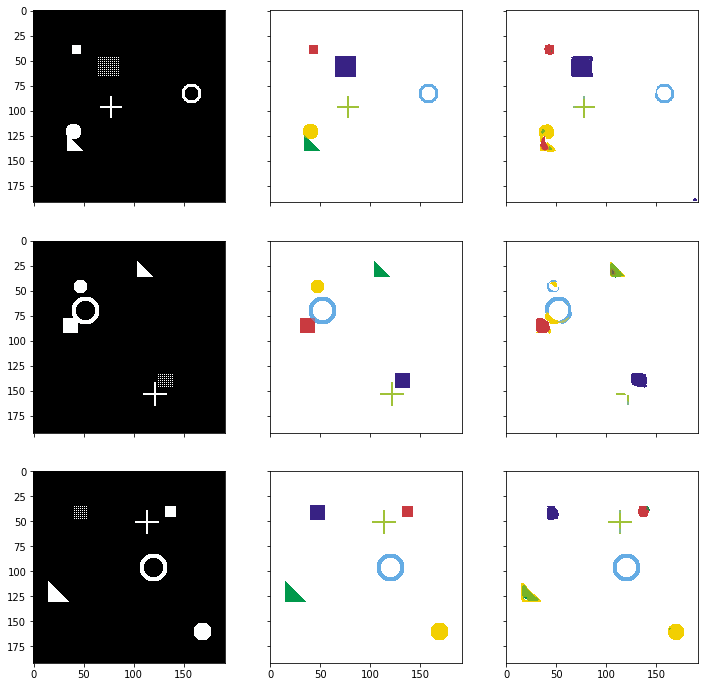

In [10]:
import math
import torchvision.utils

def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)

    return inp

model.eval()   # Set model to the evaluation mode

# Create another simulation dataset for test
test_dataset = SimDataset(3, transform = trans)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, num_workers=0)

# Get the first batch
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)

# Predict
t=time.time()
pred = model(inputs)
t1=time.time()
# The loss functions include the sigmoid function.
pred = F.sigmoid(pred)
te=time.time()
print(te-t)
pred = pred.data.cpu().numpy()
print(pred.shape)

# Change channel-order and make 3 channels for matplot
input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]

# Map each channel (i.e. class) to each color
target_masks_rgb = [helper.masks_to_colorimg(x) for x in labels.cpu().numpy()]
pred_rgb = [helper.masks_to_colorimg(x) for x in pred]

helper.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])


In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

In [0]:
tol